# 1. Extraire les probabilités de défaut implicites


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import binom, norm, skew, kurtosis, t, beta
from scipy.optimize import minimize

In [4]:
def pd_from_cds(spread_bp, maturity, recovery=0.40):
    """ 
    Fonction pour extraire les probabilité de défaut implicite
    """
    # Conversion bp -> décimal (1bp = 0.0001)
    spread = spread_bp / 10000  
    lambda_ = spread / (1 - recovery)
    pd = 1 - np.exp(-lambda_ * maturity)
    return pd

In [5]:
# Pour BNP
pd_bnp_4y = pd_from_cds(100, 4)
pd_bnp_5y = pd_from_cds(120, 5)

# Pour SG
pd_sg_4y = pd_from_cds(120, 4)
pd_sg_5y = pd_from_cds(150, 5)

print("PD BNP 4 ans :", pd_bnp_4y)
print("PD BNP 5 ans :", pd_bnp_5y)
print("PD SG 4 ans :", pd_sg_4y)
print("PD SG 5 ans :", pd_sg_5y)


PD BNP 4 ans : 0.06449301496838222
PD BNP 5 ans : 0.09516258196404048
PD SG 4 ans : 0.07688365361336424
PD SG 5 ans : 0.11750309741540454


# 2. Caractériser les distributions des taux de recouvrement de chacune des deux créances

In [6]:
# Pour carctériser les distributions des taux de recouvrement, on suppose que les recouvrement 
# suivent une loi Beta
# On déduit les paramètres à partir de la moyenne et de la volatilité

def beta_params(mean, vol):
    """  
    Fonction qui retourne les paramètres de la loi Beta à partir de la moyenne et de la volatilité
    """
    a_chapeau = (mean**2 * (1 - mean))/(vol**2) - mean
    b_chapeau = (mean**2 * (1 - mean)**2)/(mean * vol**2) - (1- mean)

    return a_chapeau, b_chapeau


In [7]:
# Pour BNP (moyenne 60 %, vol 15 %)
mean_bnp = 0.60
vol_bnp = 0.15
a_chapeau_bnp, b_chapeau_bnp = beta_params(mean_bnp, vol_bnp)

# Pour SG (moyenne 30 %, vol 25 %)
mean_sg = 0.30
vol_sg = 0.25
a_chapeau_sg, b_chapeau_sg= beta_params(mean_sg, vol_sg)

print("BNP Beta parameters: alpha =", a_chapeau_bnp, "beta =", b_chapeau_bnp)
print("SG Beta parameters: alpha =", a_chapeau_sg, "beta =", b_chapeau_sg)

BNP Beta parameters: alpha = 5.8 beta = 3.8666666666666676
SG Beta parameters: alpha = 0.708 beta = 1.652


## Interpétation :
  - ## Pour BNP : a > b donc asymétrie à droite
  - ## Pur SG : a < b  donc asymétrie à gauche ?

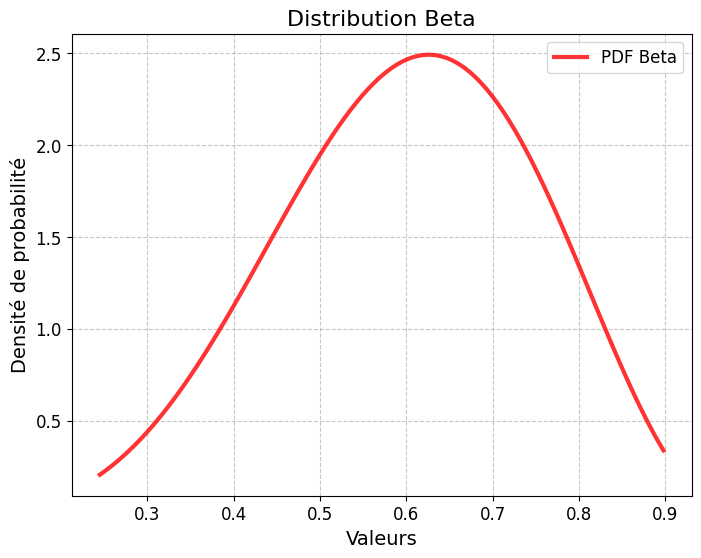

In [8]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

def plot_beta_distribution(a_chapeau, b_chapeau):
    """
    Affiche un graphique de la distribution Beta avec les paramètres donnés.

    Paramètres :
    a_chapeau : float : paramètre alpha de la distribution Beta
    b_chapeau : float : paramètre beta de la distribution Beta
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    x = np.linspace(beta.ppf(0.01, a_chapeau, b_chapeau),
                    beta.ppf(0.99, a_chapeau, b_chapeau), 100)
    y = beta.pdf(x, a_chapeau, b_chapeau)

    ax.plot(x, y, 'r-', lw=3, alpha=0.8, label='PDF Beta')

    ax.set_title('Distribution Beta', fontsize=16)
    ax.set_xlabel('Valeurs', fontsize=14)
    ax.set_ylabel('Densité de probabilité', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='best', fontsize=12)

    plt.show()

plot_beta_distribution(a_chapeau_bnp, b_chapeau_bnp)

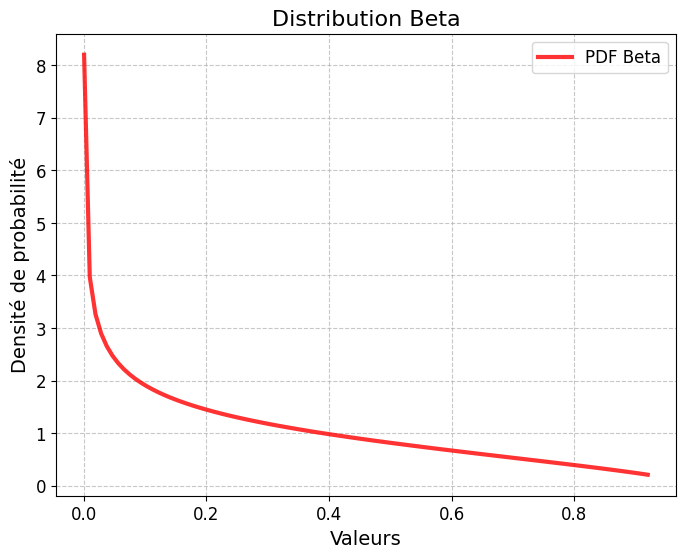

In [9]:
plot_beta_distribution(a_chapeau_sg, b_chapeau_sg)

# 3. On s’intéresse à l’historique des données actions. 
## 3.a. Effectuer une analyse exploratoire univariée des données actions de ces deux entreprises

In [10]:
# Chargement des données
data = pd.read_csv("data.txt", sep="\s+", header=0)
data.head()

,BNP,SG
0,42.36,55.24
1,42.72,55.59
2,43.20,56.45
3,42.67,55.55
4,41.81,54.50


In [11]:
data.describe()

,BNP,SG
count,1000.000000,1000.000000
mean,31.906254,43.532641
std,9.630129,10.007847
min,14.056200,21.667700
25%,23.450325,36.065350
50%,34.353700,46.824800
75%,40.229375,51.291675
max,48.330000,60.680000


In [12]:
data_returns = np.log(data/data.shift(1)).dropna()
data_returns.head(3)

,BNP,SG
1,0.008463,0.006316
2,0.011173,0.015352
3,-0.012344,-0.016072


In [13]:
data_returns.describe()

,BNP,SG
count,999.000000,999.000000
mean,-0.000888,-0.000687
std,0.024441,0.020731
min,-0.123524,-0.098292
25%,-0.013867,-0.011830
50%,-0.000358,-0.000547
75%,0.012526,0.011223
max,0.083225,0.076478


In [14]:
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller

def analyze_data(df, name="Dataset"):
    """
    Analyse les données du DataFrame fourni et retourne un DataFrame avec :
    - Statistiques descriptives
    - Tests de normalité (Shapiro-Wilk)
    - Tests de stationnarité (Dickey-Fuller)

    Paramètres :
    df : DataFrame : Doit contenir les colonnes 'Close' et 'Rendement'
    name : str : Nom du dataset (optionnel)

    Retourne :
    results : DataFrame avec toutes les analyses
    """
    # Vérification de la présence des colonnes nécessaires
    if not {'Close', 'Rendement'}.issubset(df.columns):
        raise ValueError("Le DataFrame doit contenir les colonnes 'Close' et 'Rendement'.")

    # Statistiques descriptives
    results = df[['Close', 'Rendement']].describe()
    results['Indicateur'] = ["Nombre", "Moyenne", "Ecart-Type", "Minimum", "Percentile 25%", "Médiane", "Percentile 75%", "Maximum"]
    results = results[['Indicateur', 'Close', 'Rendement']]

    # Test de normalité (Shapiro-Wilk)
    _, p_rend = shapiro(df['Rendement'].dropna())
    _, p_close = shapiro(df['Close'].dropna())
    results = pd.concat([results, pd.DataFrame([["Normalité (p)", p_close, p_rend]], columns=results.columns)])

    # Test de stationnarité (Dickey-Fuller)
    _, p_value_rend = adfuller(df['Rendement'].dropna())[:2]
    _, p_value_close = adfuller(df['Close'].dropna())[:2]
    results = pd.concat([results, pd.DataFrame([["Stationnarité (p)", p_value_close, p_value_rend]], columns=results.columns)])

    return results

data_bnp = pd.concat([data["BNP"], data_returns["BNP"]], axis=1)
data_bnp.columns = ['Close', 'Rendement']  # Renommage des colonnes

analyze_data(data_bnp)

,Indicateur,Close,Rendement
count,Nombre,1.000000e+03,9.990000e+02
mean,Moyenne,3.190625e+01,-8.875748e-04
std,Ecart-Type,9.630129e+00,2.444100e-02
min,Minimum,1.405620e+01,-1.235235e-01
25%,Percentile 25%,2.345032e+01,-1.386684e-02
50%,Médiane,3.435370e+01,-3.578458e-04
75%,Percentile 75%,4.022938e+01,1.252624e-02
max,Maximum,4.833000e+01,8.322452e-02
0,Normalité (p),2.361886e-21,7.315078e-12
0,Stationnarité (p),7.943908e-01,0.000000e+00


In [15]:
data_sg = pd.concat([data["SG"], data_returns["SG"]], axis=1)
data_sg.columns = ['Close', 'Rendement']  # Renommage des colonnes

analyze_data(data_sg)

,Indicateur,Close,Rendement
count,Nombre,1.000000e+03,9.990000e+02
mean,Moyenne,4.353264e+01,-6.874575e-04
std,Ecart-Type,1.000785e+01,2.073120e-02
min,Minimum,2.166770e+01,-9.829201e-02
25%,Percentile 25%,3.606535e+01,-1.182979e-02
50%,Médiane,4.682480e+01,-5.468895e-04
75%,Percentile 75%,5.129167e+01,1.122288e-02
max,Maximum,6.068000e+01,7.647830e-02
0,Normalité (p),2.019151e-20,4.726505e-12
0,Stationnarité (p),7.361591e-01,8.678531e-09


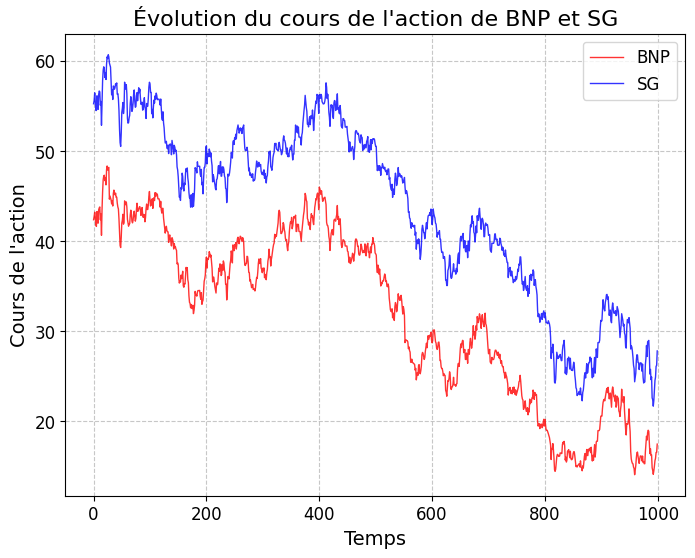

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(data["BNP"], 'r-', lw=1, alpha=0.8, label='BNP')
ax.plot(data["SG"], 'b-', lw=1, alpha=0.8, label='SG')
ax.set_title("Évolution du cours de l'action de BNP et SG", fontsize=16)
ax.set_xlabel('Temps', fontsize=14)
ax.set_ylabel("Cours de l'action", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='best', fontsize=12)
plt.show()

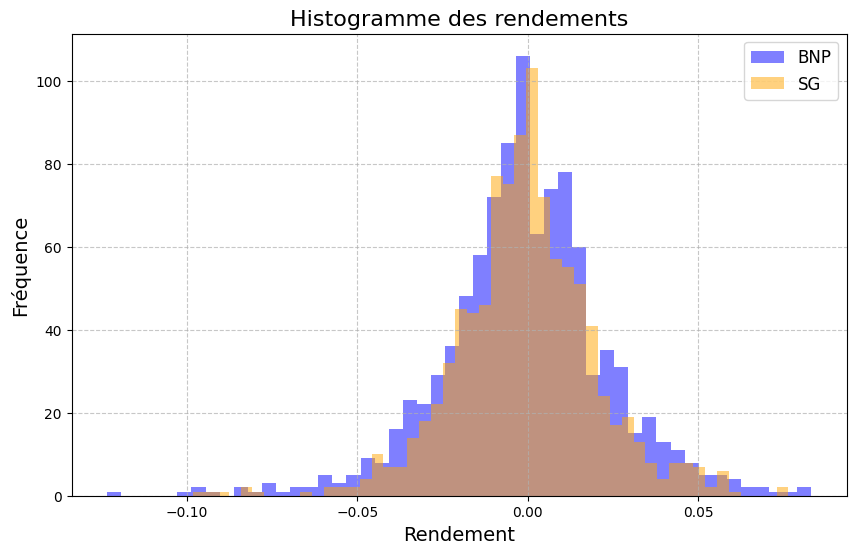

In [17]:
# Création de la figure et des axes
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# Création de l'histogramme
ax.hist(data_returns['BNP'], bins=50, alpha=0.5, label="BNP", color='blue')
ax.hist(data_returns['SG'], bins=50, alpha=0.5, label="SG", color='orange')
# Ajout du titre et des légendes
ax.set_title("Histogramme des rendements", fontsize=16)
ax.set_xlabel("Rendement", fontsize=14)
ax.set_ylabel("Fréquence", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
# Personnalisation de la grille
ax.grid(True, linestyle='--', alpha=0.7)
# Affichage du graphique
plt.show()

## 3.b Modéliser judicieusement les distributions univariées des facteurs de risques

In [18]:
def skew_t_pdf(x, params):
    """
    Densité de probabilité de la loi Skew Student.

    Paramètres :
    - x : Valeurs pour lesquelles calculer la densité.
    - mu : Moyenne de la distribution.
    - nu : Degrés de liberté de la loi t.
    - sigma : Écart-type de la distribution.
    - gamma : Paramètre de skewness (asymétrie).

    Retour :
    - La densité de probabilité pour chaque valeur de x.
    """
    mu, nu, sigma, gamma = params
    # Calcul de la densité de la loi Student standard avec nu degrés de liberté
    z = (x - mu) / sigma
    student_pdf = t.pdf(x, df=nu, loc = mu, scale=sigma)

    # Calcul de la CDF de la Student avec (nu + 1) degrés de liberté, et ajustement avec gamma
    student_cdf = t.cdf(gamma*z*np.sqrt((nu+1)/(z**2 + nu)), df=nu + 1)

    # Retour de la densité de la Skew-Student avec facteur d'asymétrie
    return 2 * student_pdf * student_cdf

In [19]:
def neg_log_likelihood(params, x):
    """Log-vraisemblance négative à minimiser"""
    mu, nu, sigma, gamma = params

    return -np.sum(np.log(np.maximum(skew_t_pdf(x, params), 10e-10)))

In [20]:
def estimate_skew_t_params(x):
    """Estimation des paramètres par maximum de vraisemblance"""
    init_params = [0, 2, 0.1, 0]  # Initialisation
    bounds = [(0, None), (2, None), (10e-6, None), (-1, 1)]

    result = minimize(neg_log_likelihood, init_params, args=(x,), bounds=bounds, method='L-BFGS-B')

    if result.success:
        return result.x
    else:
        raise ValueError("L'optimisation a échoué.")

In [21]:
from scipy.special import gamma as gamma_func

# -----------------------------------------------------------------------------
# Fonctions de la loi t et de sa version généralisée
# -----------------------------------------------------------------------------

def student_pdf(x, nu):
    """
    Densité de la loi t standard à nu degrés de liberté.
    """
    coeff = gamma_func((nu + 1) / 2) / (np.sqrt(nu * np.pi) * gamma_func(nu / 2))
    return coeff * (1 + x**2 / nu) ** (-(nu + 1) / 2)

def student_cdf(x, nu):
    """
    Fonction de répartition de la loi t standard.
    """
    return t.cdf(x, df=nu)

def student_gen_pdf(x, mu, sigma, nu):
    """
    Densité de la loi t généralisée.
    """
    z = (x - mu) / sigma
    coeff = gamma_func((nu + 1) / 2) / (sigma * np.sqrt((nu - 2) * np.pi) * gamma_func(nu / 2))
    return coeff * (1 + z**2 / (nu - 2)) ** (-(nu + 1) / 2)

def student_gen_cdf(x, mu, sigma, nu):
    """
    Fonction de répartition de la loi t généralisée.
    Transformation selon : y = (x - mu) / (sigma * sqrt((nu - 2) / nu))
    """
    sigma_v = sigma * np.sqrt((nu - 2) / nu) 
    z = (x - mu) / sigma_v
    return t.cdf(z, df=nu)

# -----------------------------------------------------------------------------
# Densité de la loi Skew-Student
# -----------------------------------------------------------------------------

def skew_student_pdf(x, mu, sigma, gamma, nu):
    """
    Densité de la loi skew-t selon Hansen.
    """
    z = (x - mu) / sigma
    f_sym = student_gen_pdf(x, mu, sigma, nu)
    gamma_arg = gamma * z * np.sqrt((nu + 1) / (nu + z**2))
    gamma_cdf = t.cdf(gamma_arg, df=nu + 1)
    return 2 * f_sym * gamma_cdf

# -----------------------------------------------------------------------------
# Vraisemblance et estimation par Maximum de Vraisemblance (MLE)
# -----------------------------------------------------------------------------

def log_likelihood_skew_student(params, data):
    """
    Calcule le log-vraisemblance négatif pour un échantillon donné.
    """
    mu, sigma, gamma, nu = params
    log_likelihood = 0
    for x in data:
        pdf_val = skew_student_pdf(x, mu, sigma, gamma, nu)
        if pdf_val <= 0 or np.isnan(pdf_val):
            return np.inf
        log_likelihood += np.log(pdf_val)
    return -log_likelihood

def fit_skew_student_mle(data):
    """
    Estime les paramètres (mu, sigma, gamma, nu) par Maximum de Vraisemblance.
    """
    initial_guess = (np.mean(data), np.std(data), 0.5, 4.0)
    bounds = [(None, None), (1e-6, None), (None, None), (2, None)]
    result = minimize(log_likelihood_skew_student, initial_guess, args=(data,), method="L-BFGS-B", bounds=bounds)
    
    if not result.success:
        raise RuntimeError("L'optimisation a échoué : " + result.message)
    
    return result.x  # Renvoie (mu, sigma, gamma, nu)

In [22]:
try:
    params_estimated_bnp = fit_skew_student_mle(data_returns["BNP"].dropna())
    print("Paramètres estimés BNP (mu, sigma, gamma, nu) :", params_estimated_bnp)
except Exception as e:
    print("Erreur lors de l'estimation :", e)

Paramètres estimés BNP (mu, sigma, gamma, nu) : [ 1.27623299e-03  2.50545660e-02 -1.34745851e-01  4.56957665e+00]


In [23]:
try:
    params_estimated_sg = fit_skew_student_mle(data_returns["SG"].dropna())
    print("Paramètres estimés SG (mu, sigma, gamma, nu) :", params_estimated_sg)
except Exception as e:
    print("Erreur lors de l'estimation :", e)

Paramètres estimés SG (mu, sigma, gamma, nu) : [-1.42354772e-03  2.17975944e-02  6.43053433e-02  4.06704948e+00]


In [24]:
"""
mu_bnp, nu_bnp, sigma_bnp, gamma_bnp = estimate_skew_t_params(data_returns["BNP"].dropna())
print(f"Paramètres estimés pour BNP: mu = {mu_bnp:.4f}, nu = {nu_bnp:.4f}, sigma = {sigma_bnp:.4f}, gamma = {gamma_bnp:.4f}")
"""

'\nmu_bnp, nu_bnp, sigma_bnp, gamma_bnp = estimate_skew_t_params(data_returns["BNP"].dropna())\nprint(f"Paramètres estimés pour BNP: mu = {mu_bnp:.4f}, nu = {nu_bnp:.4f}, sigma = {sigma_bnp:.4f}, gamma = {gamma_bnp:.4f}")\n'

In [25]:
"""
mu_bnp, nu_bnp, sigma_bnp, gamma_bnp = estimate_skew_t_params(data_returns["BNP"].dropna())
print(f"Paramètres estimés pour BNP: mu = {mu_bnp:.4f}, nu = {nu_bnp:.4f}, sigma = {sigma_bnp:.4f}, gamma = {gamma_bnp:.4f}")
"""

'\nmu_bnp, nu_bnp, sigma_bnp, gamma_bnp = estimate_skew_t_params(data_returns["BNP"].dropna())\nprint(f"Paramètres estimés pour BNP: mu = {mu_bnp:.4f}, nu = {nu_bnp:.4f}, sigma = {sigma_bnp:.4f}, gamma = {gamma_bnp:.4f}")\n'

In [26]:
"""
mu_sg, nu_sg, sigma_sg, gamma_sg = estimate_skew_t_params(data_returns["SG"].dropna())
print(f"Paramètres estimés pour SG : mu = {mu_sg:.4f}, nu = {nu_sg:.4f}, sigma = {sigma_sg:.4f}, gamma = {gamma_sg:.4f}")
"""

'\nmu_sg, nu_sg, sigma_sg, gamma_sg = estimate_skew_t_params(data_returns["SG"].dropna())\nprint(f"Paramètres estimés pour SG : mu = {mu_sg:.4f}, nu = {nu_sg:.4f}, sigma = {sigma_sg:.4f}, gamma = {gamma_sg:.4f}")\n'

In [27]:
"""
def skew_student_quantile(params, prob, size=100000):

    mu, nu, sigma, gamma = params
    T_g1 = stats.t.rvs(df=nu, size=size)
    T_g2 = stats.t.rvs(df=nu, size=size)

    Z = mu + sigma / np.sqrt(1 + gamma**2) * (gamma * T_g1 + T_g2)

    return np.percentile(Z, 100 * (prob))
"""

'\ndef skew_student_quantile(params, prob, size=100000):\n\n    mu, nu, sigma, gamma = params\n    T_g1 = stats.t.rvs(df=nu, size=size)\n    T_g2 = stats.t.rvs(df=nu, size=size)\n\n    Z = mu + sigma / np.sqrt(1 + gamma**2) * (gamma * T_g1 + T_g2)\n\n    return np.percentile(Z, 100 * (prob))\n'

In [28]:
# -----------------------------------------------------------------------------
# Création de la fonction inverse de la CDF (fonction quantile) par intégration
# par la méthode des trapèzes (vectorisée, sans appel à quad)
# -----------------------------------------------------------------------------

def create_skew_student_inverse_cdf(params, lower, upper, num_points=10000):
    """
    Construit une approximation de la fonction quantile pour la loi Skew-Student
    en créant une grille d'intégration par la méthode des trapèzes.
    
    params    : (mu, sigma, gamma, nu)
    lower     : borne inférieure de la grille
    upper     : borne supérieure de la grille
    num_points: nombre de points sur la grille
    """
    mu, sigma, gamma, nu = params
    x_grid = np.linspace(lower, upper, num_points)
    pdf_vals = skew_student_pdf(x_grid, mu, sigma, gamma, nu)
    
    # Intégration cumulative par la méthode des trapèzes
    dx = x_grid[1] - x_grid[0]
    cdf_vals = np.cumsum(pdf_vals) * dx
    # Normaliser pour que la dernière valeur soit 1
    cdf_vals /= cdf_vals[-1]
    
    # Retourne une fonction qui, pour une probabilité p, interpole le quantile correspondant
    def inverse_cdf(p):
        return np.interp(p, cdf_vals, x_grid)
    
    return inverse_cdf

# -----------------------------------------------------------------------------
# Fonction pour afficher le QQ-plot sans utiliser d'intégrales à chaque quantile
# -----------------------------------------------------------------------------

def qq_plot(x, params):
    """
    QQ-plot pour comparer les quantiles empiriques et théoriques d'une loi Skew‑Student.
    
    Paramètres :
      - x      : vecteur de données (ex : rendements)
      - params : paramètres (mu, sigma, gamma, nu) de la loi Skew‑Student
    """
    sorted_x = np.sort(x)
    n = len(x)
    
    # Définir les bornes pour la grille en se basant sur les données empiriques
    lower = np.min(sorted_x) - 2 * np.std(sorted_x)
    upper = np.max(sorted_x) + 2 * np.std(sorted_x)
    
    # Créer la fonction inverse de la CDF (quantile) sur une grille
    inv_cdf = create_skew_student_inverse_cdf(params, lower, upper, num_points=10000)
    
    # Calcul des probabilités associées aux quantiles
    p_vals = np.linspace(1/n, 1, n)
    theoretical_quantiles = inv_cdf(p_vals)
    
    # Affichage du QQ-plot
    plt.figure(figsize=(6,6))
    plt.scatter(theoretical_quantiles, sorted_x, label="Données empiriques")
    plt.plot(theoretical_quantiles, theoretical_quantiles, 'r--', label="Ligne x = y")
    plt.xlabel("Quantiles théoriques (Skew‑Student)")
    plt.ylabel("Quantiles empiriques")
    plt.legend()
    plt.title("QQ-plot Skew‑Student")
    plt.show()

Paramètres estimés BNP (mu, sigma, gamma, nu) : [ 1.27623299e-03  2.50545660e-02 -1.34745851e-01  4.56957665e+00]


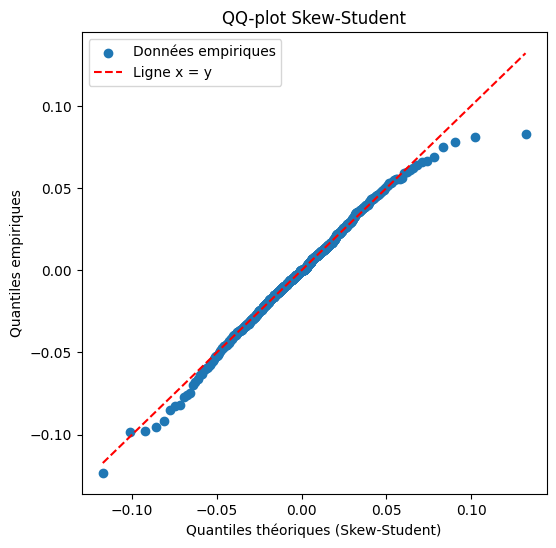

In [29]:
try:
    # Estimation des paramètres (en enlevant les valeurs manquantes)
    params_estimated_bnp = fit_skew_student_mle(data_returns["BNP"].dropna())
    print("Paramètres estimés BNP (mu, sigma, gamma, nu) :", params_estimated_bnp)
except Exception as e:
    print("Erreur lors de l'estimation :", e)

# Affichage du QQ-plot avec les paramètres estimés
qq_plot(data_returns["BNP"].dropna(), params_estimated_bnp)


Paramètres estimés SG (mu, sigma, gamma, nu) : [-1.42354772e-03  2.17975944e-02  6.43053433e-02  4.06704948e+00]


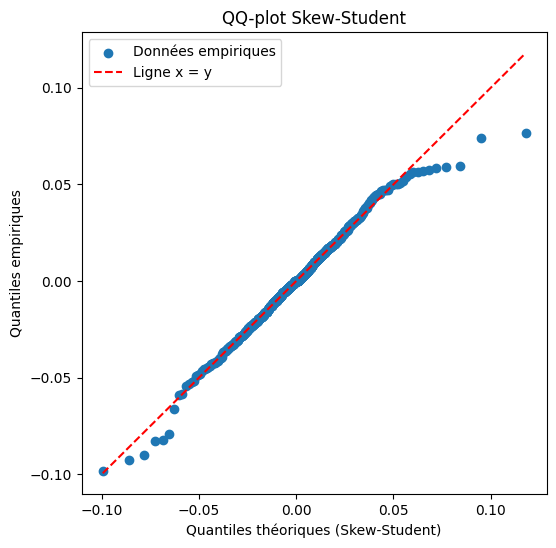

In [30]:
try:
    # Estimation des paramètres (en enlevant les valeurs manquantes)
    params_estimated_sg = fit_skew_student_mle(data_returns["SG"].dropna())
    print("Paramètres estimés SG (mu, sigma, gamma, nu) :", params_estimated_sg)
except Exception as e:
    print("Erreur lors de l'estimation :", e)

# Affichage du QQ-plot avec les paramètres estimés
qq_plot(data_returns["SG"].dropna(), params_estimated_sg)


In [31]:
# e. Calcul de la VaR Skew-Student à 99%
def var_skew_t(alpha, params):
    """
    Calcul de la VaR à alpha% pour une loi Skew-Student en utilisant 
    l'approximation de la fonction quantile (inverse CDF).
    """
    mu, sigma, gamma, nu = params
    
    # Définir les bornes pour la grille en fonction des paramètres
    lower = mu - 5 * sigma
    upper = mu + 5 * sigma
    
    # Créer la fonction inverse de la CDF sur une grille
    inv_cdf = create_skew_student_inverse_cdf(params, lower, upper, num_points=10000)
    
    # Calcul de la VaR (1 - alpha) quantile
    return inv_cdf(1 - alpha)

# Calcul de la VaR à 99% pour BNP et SG
params_bnp = (params_estimated_bnp)
params_sg = (params_estimated_sg)

var_99_bnp = var_skew_t(0.99, params_bnp)
var_99_sg = var_skew_t(0.99, params_sg)

print(f"VaR Skew-Student à 99% de BNP : {var_99_bnp:.4f}")
print(f"VaR Skew-Student à 99% de SG  : {var_99_sg:.4f}")


VaR Skew-Student à 99% de BNP : -0.0663
VaR Skew-Student à 99% de SG  : -0.0560


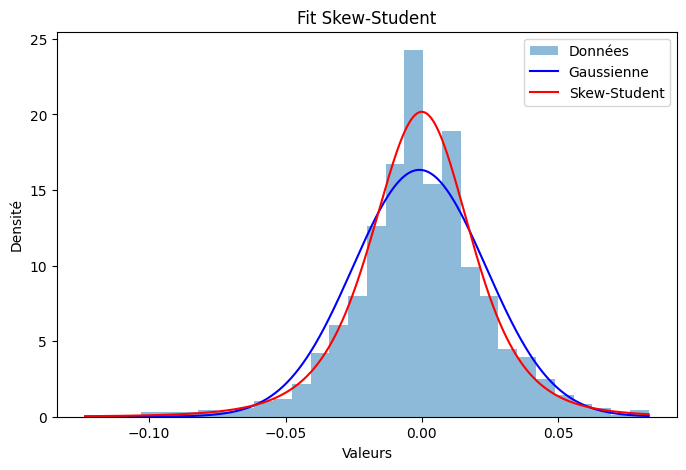

In [32]:
# d. Comparaison des fits
def plot_fit_comparison(x, params_skew_t):
    """Comparaison des fits entre la loi gaussienne et la loi Skew-Student."""
    plt.figure(figsize=(8,5))
    # Histogramme des données
    plt.hist(x, bins=30, density=True, alpha=0.5, label="Données")
    # Densité gaussienne
    mu_norm, sigma_norm = np.mean(x), np.std(x)
    x_vals = np.linspace(min(x), max(x), 1000)
    plt.plot(x_vals, stats.norm.pdf(x_vals, mu_norm, sigma_norm), label="Gaussienne", color='blue')
    # Densité Skew-Student
    plt.plot(x_vals, skew_student_pdf(x_vals, params_skew_t[0], params_skew_t[1], params_skew_t[2],params_skew_t[3]),
              label="Skew-Student", color='red')
    plt.xlabel("Valeurs")
    plt.ylabel("Densité")
    plt.legend()
    plt.title("Fit Skew-Student")
    plt.show()

plot_fit_comparison(data_returns["BNP"].dropna(), params_estimated_bnp)

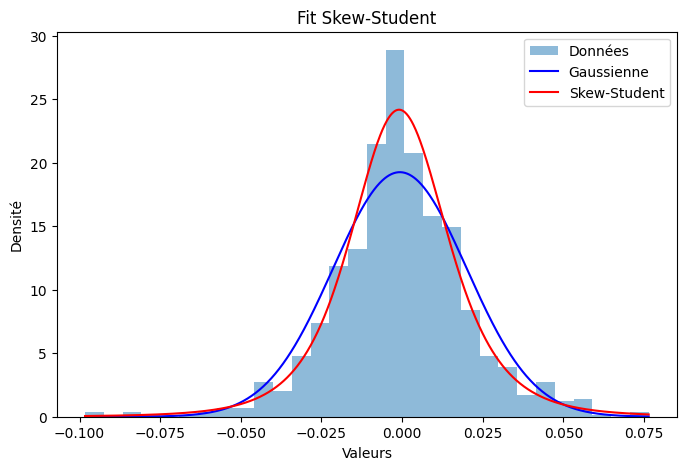

In [33]:
plot_fit_comparison(data_returns["SG"].dropna(), params_estimated_sg)

### Normale Inverse Gaussienne

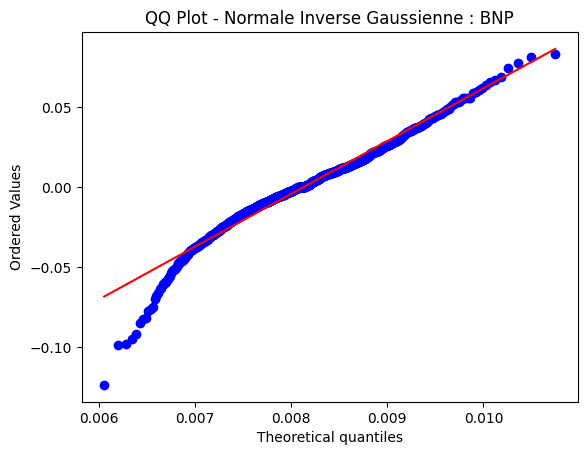

In [34]:
# Ajustement de la distribution normale inverse gaussienne
params_bnp = stats.invgauss.fit(data_returns["BNP"])

# Tracé du QQ plot
fig, ax = plt.subplots()
stats.probplot(data_returns["BNP"], dist="invgauss", sparams=params_bnp[:-2], plot=ax)
ax.set_title('QQ Plot - Normale Inverse Gaussienne : BNP')
plt.show()

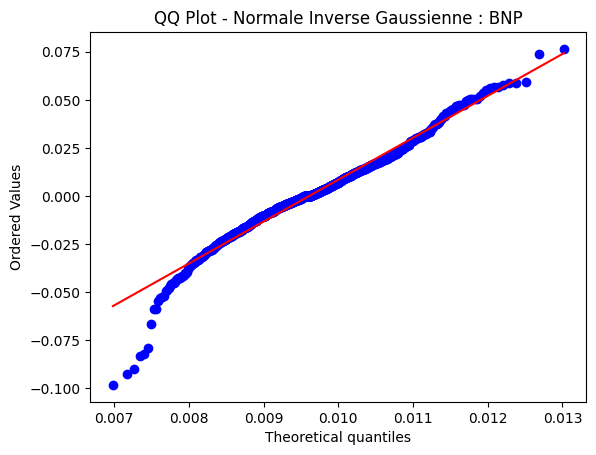

In [35]:
# Ajustement de la distribution normale inverse gaussienne
params_sg = stats.invgauss.fit(data_returns["SG"])

# Tracé du QQ plot
fig, ax = plt.subplots()
stats.probplot(data_returns["SG"], dist="invgauss", sparams=params_sg[:-2], plot=ax)
ax.set_title('QQ Plot - Normale Inverse Gaussienne : BNP')
plt.show()

Corrélation de Pearson :
           BNP        SG
BNP  1.000000  0.863498
SG   0.863498  1.000000
Corrélation de Spearman :
           BNP        SG
BNP  1.000000  0.840957
SG   0.840957  1.000000
Corrélation de Kendall :
           BNP        SG
BNP  1.000000  0.669096
SG   0.669096  1.000000


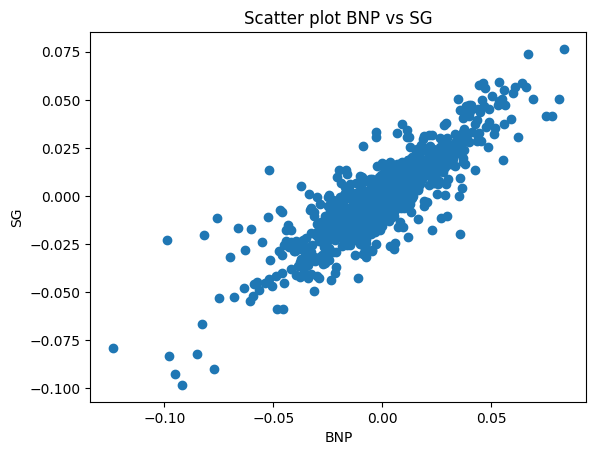

In [36]:
# Calcul des corrélations
print("Corrélation de Pearson :\n", data_returns.corr(method="pearson"))
print("Corrélation de Spearman :\n", data_returns.corr(method="spearman"))
print("Corrélation de Kendall :\n", data_returns.corr(method="kendall"))

# Nuage de points
plt.scatter(data_returns['BNP'], data_returns['SG'])
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Scatter plot BNP vs SG")
plt.show()

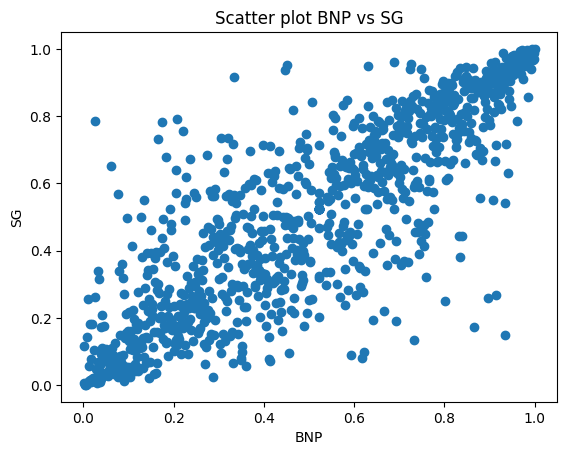

In [37]:
data_uniform = data_returns.rank(method='average', pct=True)
# Nuage de points
plt.scatter(data_uniform['BNP'], data_uniform['SG'])
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Scatter plot BNP vs SG")
plt.show()

# 5. Modéliser la structure de dépendance au moyen des copules paramétriques suivantes :

## 5.a. Copules elliptiques : gaussienne, Student. 

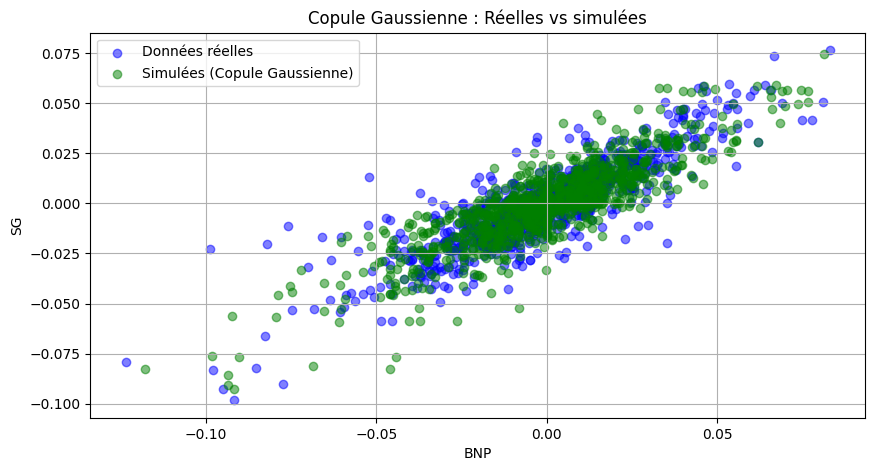

In [ ]:
from copulae import GaussianCopula

# 1. Correction des index dupliqués
data_returns = data_returns.reset_index(drop=True)

# 2. Transformation des données en rangs (pour obtenir des valeurs uniformes dans [0, 1])
rank_data = data_returns.rank() / (len(data_returns) + 1)

# 3. Ajustement de la copule Gaussienne sur les rangs
copula_gaussian = GaussianCopula(dim=2)  # 2 variables
copula_gaussian.fit(rank_data.values)

# 4. Génération d'échantillons de la copule (valeurs sur [0, 1])
samples = copula_gaussian.random(len(data_returns['BNP']))

# 5. Transformation inverse des rangs vers l'échelle originale
# Utilisation de np.percentile qui prend en argument les pourcentages (multipliez par 100)
simulated_BNP = np.percentile(data_returns['BNP'], samples[:, 0] * 100)
simulated_SG  = np.percentile(data_returns['SG'], samples[:, 1] * 100)
simulated_returns = pd.DataFrame({
    'BNP': simulated_BNP,
    'SG': simulated_SG
})

# 6. Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(data_returns['BNP'], data_returns['SG'], alpha=0.5, label="Données réelles", color="blue")
plt.scatter(simulated_returns['BNP'], simulated_returns['SG'], alpha=0.5, label="Simulées (Copule Gaussienne)", color="green")
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Copule Gaussienne : Réelles vs simulées")
plt.legend()
plt.grid(True)
plt.show()


In [107]:
copula_gaussian.summary()

1.000000,0.860948
0.860948,1.000000


# 5. Modéliser la structure de dépendance au moyen des copules paramétriques suivantes : 

## Copules elliptiques : gaussienne, Student.

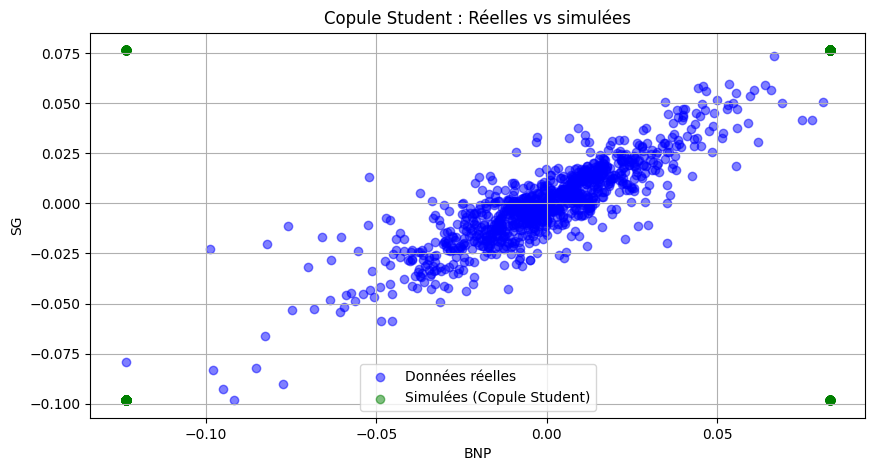

In [ ]:
from copulae import StudentCopula

# 1. Correction des index dupliqués
data_returns = data_returns.reset_index(drop=True)

# 2. Transformation des données en rangs (pour obtenir des valeurs uniformes dans [0, 1])
rank_data = data_returns.rank() / (len(data_returns) + 1)

# 3. Ajustement de la copule Student sur les rangs
copula_student = StudentCopula(dim=2)  # 2 variables
copula_student.fit(rank_data.values)

# 4. Génération d'échantillons de la copule (valeurs sur [0, 1])
samples = copula_student.random(len(data_returns['BNP']))

# 5. Transformation inverse des rangs vers l'échelle originale
# Utilisation de np.percentile qui prend en argument les pourcentages (multipliez par 100)
simulated_BNP = np.percentile(data_returns['BNP'], samples[:, 0] * 100)
simulated_SG  = np.percentile(data_returns['SG'], samples[:, 1] * 100)
simulated_returns = pd.DataFrame({
    'BNP': simulated_BNP,
    'SG': simulated_SG
})

# 6. Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(data_returns['BNP'], data_returns['SG'], alpha=0.5, label="Données réelles", color="blue")
plt.scatter(simulated_returns['BNP'], simulated_returns['SG'], alpha=0.5, label="Simulées (Copule Student)", color="green")
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Copule Student : Réelles vs simulées")
plt.legend()
plt.grid(True)
plt.show()

In [106]:
copula_student.summary()

1.000000,0.849184
0.849184,1.000000


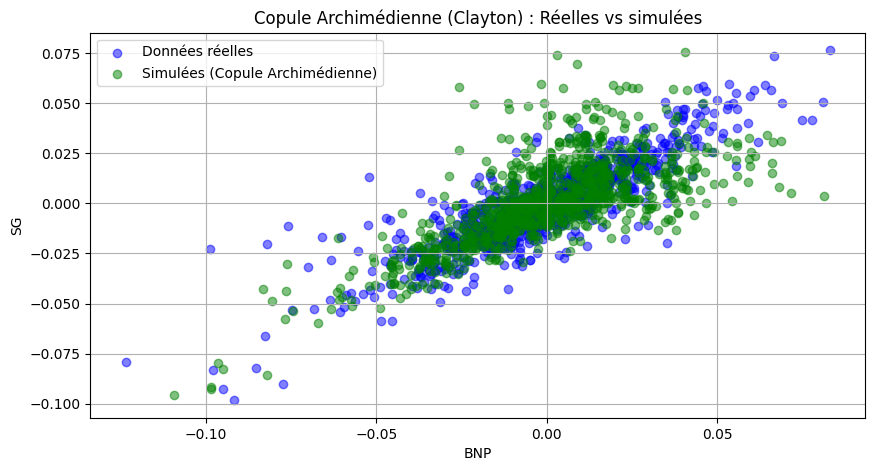

In [ ]:
from copulae import ClaytonCopula

# 1. Correction des index dupliqués
data_returns = data_returns.reset_index(drop=True)

# 2. Transformation des données en rangs (pour obtenir des valeurs uniformes dans [0, 1])
rank_data = data_returns.rank() / (len(data_returns) + 1)

# 3. Ajustement de la copule Archimédienne (ici, la ClaytonCopula) sur les rangs
copula_arch = ClaytonCopula(dim=2)  # 2 variables : 'BNP' et 'SG'
copula_arch.fit(rank_data.values)

# 4. Génération d'échantillons de la copule (valeurs dans [0, 1])
samples = copula_arch.random(1000)

# 5. Transformation inverse des rangs vers l'échelle originale
# Utilisation de np.percentile qui prend en argument des pourcentages (multipliez par 100)
simulated_BNP = np.percentile(data_returns['BNP'], samples[:, 0] * 100)
simulated_SG  = np.percentile(data_returns['SG'], samples[:, 1] * 100)
simulated_returns = pd.DataFrame({
    'BNP': simulated_BNP,
    'SG': simulated_SG
})

# 6. Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(data_returns['BNP'], data_returns['SG'], alpha=0.5, label="Données réelles", color="blue")
plt.scatter(simulated_returns['BNP'], simulated_returns['SG'], alpha=0.5, label="Simulées (Copule Archimédienne)", color="green")
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Copule Archimédienne (Clayton) : Réelles vs simulées")
plt.legend()
plt.grid(True)
plt.show()

In [105]:
copula_arch.summary()

Clayton Copula Summary
================================================================================
Clayton Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 2.476781735562753

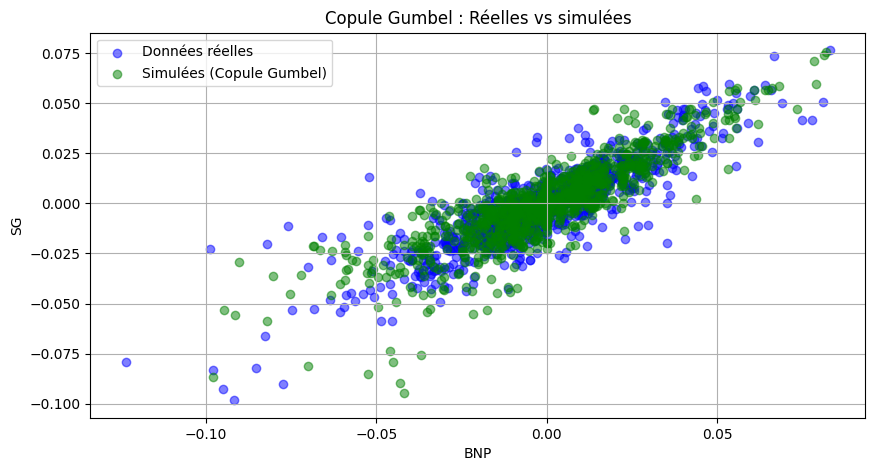

In [ ]:
from copulae import GumbelCopula

# 1. Correction des index dupliqués
data_returns = data_returns.reset_index(drop=True)

# 2. Transformation des données en rangs (pour obtenir des valeurs uniformes dans [0, 1])
rank_data = data_returns.rank() / (len(data_returns) + 1)

# 3. Ajustement de la copule Gumbel sur les rangs
copula_gumbel = GumbelCopula(dim=2)  # 2 variables
copula_gumbel.fit(rank_data.values)

# 4. Génération d'échantillons de la copule (valeurs sur [0, 1])
samples = copula_gumbel.random(1000)

# 5. Transformation inverse des rangs vers l'échelle originale
# Utilisation de np.percentile qui prend en argument des pourcentages (multipliez par 100)
simulated_BNP = np.percentile(data_returns['BNP'], samples[:, 0] * 100)
simulated_SG  = np.percentile(data_returns['SG'], samples[:, 1] * 100)
simulated_returns = pd.DataFrame({
    'BNP': simulated_BNP,
    'SG': simulated_SG
})

# 6. Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(data_returns['BNP'], data_returns['SG'], alpha=0.5, label="Données réelles", color="blue")
plt.scatter(simulated_returns['BNP'], simulated_returns['SG'], alpha=0.5, label="Simulées (Copule Gumbel)", color="green")
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Copule Gumbel : Réelles vs simulées")
plt.legend()
plt.grid(True)
plt.show()

In [108]:
copula_gumbel.summary()

Gumbel Copula Summary
================================================================================
Gumbel Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 2.9939137019539217

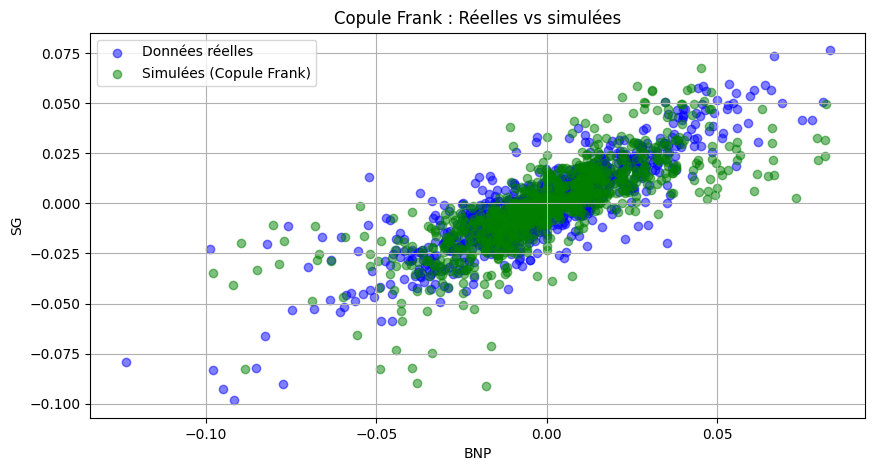

In [ ]:
from copulae import FrankCopula

# 1. Correction des index dupliqués
data_returns = data_returns.reset_index(drop=True)

# 2. Transformation des données en rangs (pour obtenir des valeurs uniformes dans [0, 1])
rank_data = data_returns.rank() / (len(data_returns) + 1)

# 3. Ajustement de la copule de Frank sur les rangs
copula_frank = FrankCopula(dim=2)  # 2 dimensions
copula_frank.fit(rank_data.values)

# 4. Génération d'échantillons de la copule (valeurs sur [0, 1])
samples = copula_frank.random(1000)

# 5. Transformation inverse des rangs vers l'échelle originale
simulated_BNP = np.percentile(data_returns['BNP'], samples[:, 0] * 100)
simulated_SG  = np.percentile(data_returns['SG'], samples[:, 1] * 100)
simulated_returns = pd.DataFrame({
    'BNP': simulated_BNP,
    'SG': simulated_SG
})

# 6. Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(data_returns['BNP'], data_returns['SG'], alpha=0.5, label="Données réelles", color="blue")
plt.scatter(simulated_returns['BNP'], simulated_returns['SG'], alpha=0.5, label="Simulées (Copule Frank)", color="green")
plt.xlabel("BNP")
plt.ylabel("SG")
plt.title("Copule Frank : Réelles vs simulées")
plt.legend()
plt.grid(True)
plt.show()

In [109]:
copula_frank.summary()

Frank Copula Summary
================================================================================
Frank Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 10.127240819074121

In [ ]:
from copulae import GaussianCopula, StudentCopula, GumbelCopula, FrankCopula
from scipy.stats import kendalltau, spearmanr

# Chargement des données
data_returns = data_returns.reset_index(drop=True)

# Transformation en pseudo-observations (rangs normalisés)
rank_data = data_returns.rank() / (len(data_returns) + 1)

# Définition des copules
copules = {
    "Gaussian": GaussianCopula(dim=2),
    "Student-t": StudentCopula(dim=2),
    "Gumbel": GumbelCopula(dim=2),
    "Frank": FrankCopula(dim=2)
}

# Ajustement des copules aux données empiriques
fit_results = {}
for name, cop in copules.items():
    cop.fit(rank_data.values)
    fit_results[name] = cop

# Comparaison des mesures de dépendance
empirical_tau, _ = kendalltau(data_returns["BNP"], data_returns["SG"])
empirical_rho, _ = spearmanr(data_returns["BNP"], data_returns["SG"])

results = []
for name, cop in fit_results.items():
    simulated_data = cop.random(len(data_returns))
    sim_tau, _ = kendalltau(simulated_data[:, 0], simulated_data[:, 1])
    sim_rho, _ = spearmanr(simulated_data[:, 0], simulated_data[:, 1])
    
    # Nouveau calcul de la log-vraisemblance via la densité jointe
    log_likelihood = np.sum(np.log(cop.pdf(rank_data.values)))

    results.append([name, log_likelihood, abs(sim_tau - empirical_tau), abs(sim_rho - empirical_rho)])

# Affichage des résultats
results_df = pd.DataFrame(results, columns=["Copule", "Log-Vraisemblance", "Erreur Kendall Tau", "Erreur Spearman Rho"])
print(results_df.sort_values(by="Log-Vraisemblance", ascending=False))

      Copule  Log-Vraisemblance  Erreur Kendall Tau  Erreur Spearman Rho
1  Student-t       24970.675632            0.016136             0.155725
2     Gumbel         703.146279            0.001541             0.009109
0   Gaussian         670.141798            0.006616             0.010123
3      Frank         630.219249            0.013870             0.035966


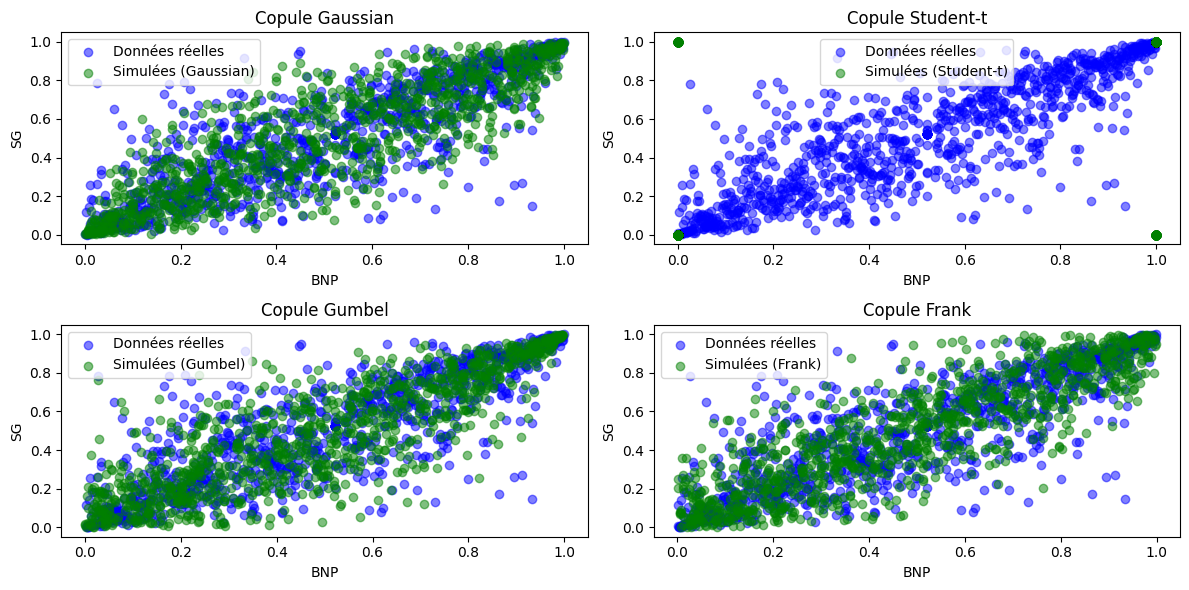

In [ ]:
# Visualisation des distributions simulées
plt.figure(figsize=(12, 6))
for i, (name, cop) in enumerate(fit_results.items(), 1):
    simulated_data = cop.random(len(data_returns))
    plt.subplot(2, 2, i)
    plt.scatter(rank_data["BNP"], rank_data["SG"], alpha=0.5, label="Données réelles", color="blue")
    plt.scatter(simulated_data[:, 0], simulated_data[:, 1], alpha=0.5, label=f"Simulées ({name})", color="green")
    plt.title(f"Copule {name}")
    plt.xlabel("BNP")
    plt.ylabel("SG")
    plt.legend()

plt.tight_layout()
plt.show()